In [138]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.svm import LinearSVC

# Task 1 Identify Features

In [310]:
df = pd.read_csv("vehicles.csv")

In [140]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [141]:
X, Y = df.drop(['id', 'url', 'region_url', 'price', 'model', 'vin', 'drive', 'image_url', 'description', 'county', 'lat', 'long'], axis=1), df['price']

### We decided to drop the above features for the following reasons:
    id, url, region_url, vin, image_url: leak target information
    model, description: irrelevant
    drive: doesn't influence price
    county: values are all 0
    lat, long: region, state are sufficient

In [142]:
X.columns

Index(['region', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'size', 'type',
       'paint_color', 'state'],
      dtype='object')

In [143]:
cat_target = ["region", "manufacturer", "state"]
cat_ohe = ["condition", "cylinders", "fuel", "title_status", "transmission", "size", "type", "paint_color"]
cont = ["year", "odometer"]

### Here are the graphs of the features we selected:

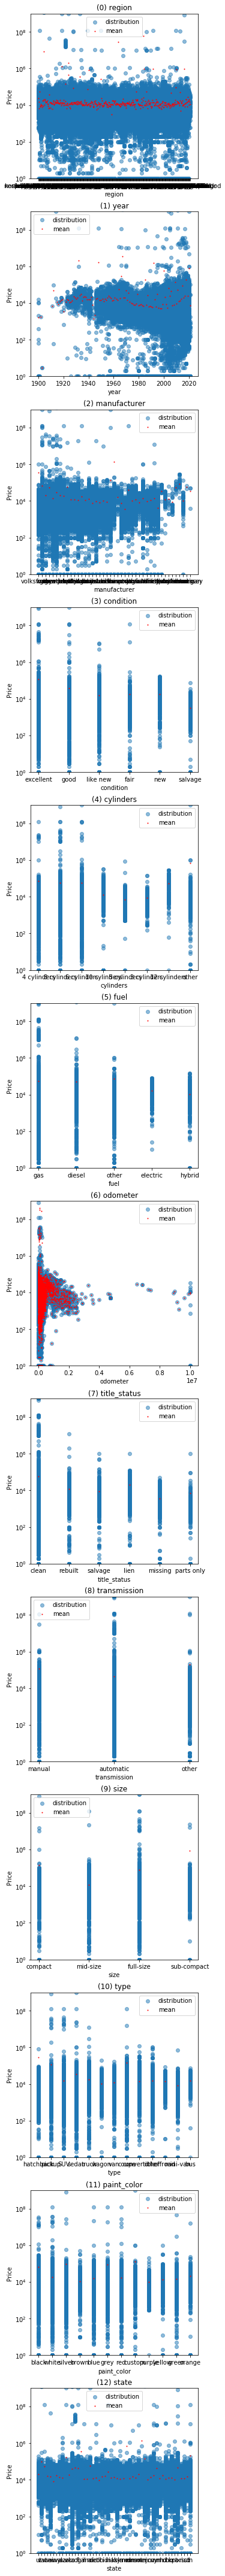

In [66]:
col = 0
fig, axes = plt.subplots(13, 1, figsize=(5, 78))
for i in range(0,13):
    axes[i].set(title='({}) {}'.format(col, X.columns[col]),
                   xlabel=X.columns[col],
                   ylabel='Price',
                   yscale='log',
                   ylim=(1,1e9))
    axes[i].scatter(X.iloc[:, col].dropna(), Y[X.iloc[:, col].notnull()], label='distribution', alpha=0.5)
    axes[i].scatter(sorted(X.iloc[:, col].dropna().unique()), Y.groupby(X.iloc[:, col]).mean(), label='mean', c='r', s=1)
    axes[i].legend()
    col += 1
plt.show()

### A red dot represents the mean price of a car with a specific feature. As shown, all these features influence a car's price and will provide relevant information to our models.

# Task 2 Baseline Model

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

In [145]:
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant'),
    OneHotEncoder(handle_unknown='ignore'))
cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler())
preprocess = make_column_transformer(
    (cat_preprocessing, make_column_selector(dtype_include='object')),
    remainder=cont_preprocessing)

In [146]:
pipe_lr = make_pipeline(preprocess, Ridge())
scores = cross_val_score(pipe_lr, X_train, y_train, cv=5)
np.mean(scores)

-0.9649426005089536

### The linear model we picked is Ridge regression, and by the R2 score produced by the model we can conclude that the dataset fits very poorly on a linear model and we should explore other more complex models for this dataset. 

# Task 3 Feature Engineering

In [311]:
# removing invalid data
df = df[df["price"] != 0]

In [312]:
# removing outliers
df = df[df['price'] < 300000]

In [313]:
X, Y = df.drop(['id', 'url', 'region_url', 'price', 'model', 'vin', 'drive', 'image_url', 'description', 'county', 'lat', 'long'], axis=1), df['price']

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

In [319]:
cont_preprocess = make_pipeline(
    SimpleImputer(),
    StandardScaler())

cat_ohe_preprocess = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown="ignore"))

cat_target_preprocess = make_pipeline(
    TargetEncoder(cols=cat_target), 
    StandardScaler())

preprocess = make_column_transformer(
    (cont_preprocess, cont),
    (cat_ohe_preprocess, cat_ohe),
    (cat_target_preprocess, cat_target))

In [175]:
pipe_lr = make_pipeline(preprocess, Ridge())
scores = cross_val_score(pipe_lr, X_train, y_train, cv=5)
np.mean(scores)

0.5065379846767913

### By cleaning the data (removing rows with price of 0) and other preprocessing techniques: 1. removing standardscaler, 2. changing the imputing strategy to be 'median' for continuous variables and 3. adding PolynomialFeatures of degree 2, the R2 score from cross validation increased significantly to close to 0. It is still a very bad score for the linear model, but we can see that in-depth preprocessing can improve the model. 

# Task 4 Any Model

In [203]:
cross_val_score(make_pipeline(preprocess, DecisionTreeRegressor(max_depth=5)), X_train, Y_train)

array([0.49571614, 0.49922937, 0.50944943, 0.50370975, 0.50378323])

In [204]:
cross_val_score(make_pipeline(preprocess, RandomForestRegressor(n_estimators=100, max_depth=5)), X_train, Y_train)

array([0.50038297, 0.5057351 , 0.51712964, 0.51174757, 0.51044377])

In [262]:
xgb_pipe = make_pipeline(preprocess, XGBRegressor(max_depth=5))
param_grid = {'xgbregressor__subsample':[0.25, 0.5, 0.75, 1]}
xgb_grid = GridSearchCV(xgb_pipe, param_grid)
xgb_grid.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
               

In [263]:
xgb_grid.best_score_

0.708222018263547

### This accuracy is far better than linear models we trained before. Therefore, we declare that our best model is a gradient boosting tree model.

# Task 5 Feature Selections

In [291]:
feature_and_importances = sorted(zip(range(74), xgb_grid.best_estimator_.get_params()['xgbregressor'].feature_importances_), key=lambda x: x[1], reverse=True)


In [292]:
feature_and_importances

[(19, 0.16323422),
 (12, 0.09231284),
 (0, 0.06779696),
 (10, 0.06161471),
 (50, 0.05618112),
 (15, 0.05086484),
 (49, 0.043480653),
 (68, 0.023147218),
 (1, 0.022243243),
 (45, 0.021104641),
 (51, 0.01933917),
 (26, 0.018508183),
 (4, 0.017805014),
 (56, 0.017329779),
 (21, 0.016680414),
 (5, 0.016385367),
 (25, 0.0148111535),
 (9, 0.014102616),
 (35, 0.012622732),
 (62, 0.012540245),
 (41, 0.011957979),
 (44, 0.0117284255),
 (3, 0.010562232),
 (22, 0.01023952),
 (43, 0.01008509),
 (67, 0.009198417),
 (6, 0.008217015),
 (24, 0.008150262),
 (14, 0.007851887),
 (33, 0.007832615),
 (34, 0.007509404),
 (2, 0.0071210247),
 (32, 0.006411173),
 (36, 0.0062349145),
 (40, 0.005975025),
 (52, 0.0058696554),
 (16, 0.0058423197),
 (55, 0.0054801754),
 (18, 0.005161514),
 (7, 0.0048782555),
 (69, 0.004679912),
 (38, 0.0044201836),
 (54, 0.004381202),
 (11, 0.004293845),
 (29, 0.004052928),
 (57, 0.0038046483),
 (46, 0.0036818192),
 (59, 0.0035597442),
 (48, 0.003543923),
 (47, 0.0034443766),
 (31,

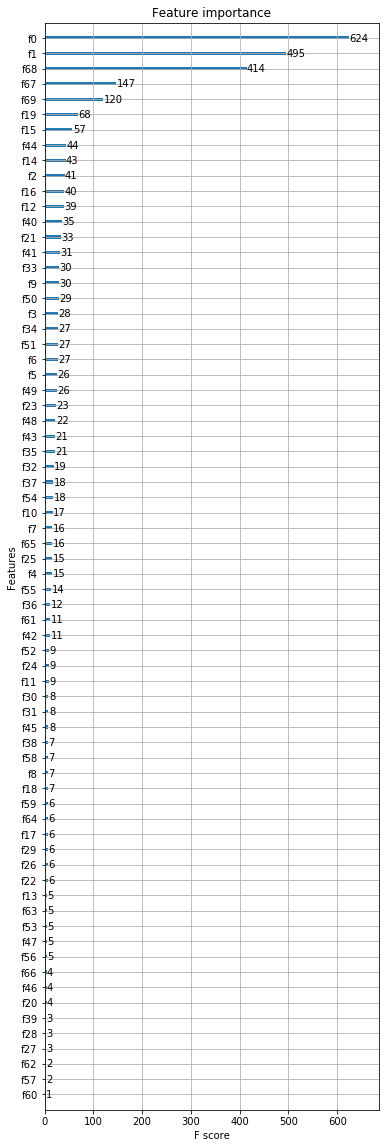

In [268]:
plot_importance(xgb_grid.best_estimator_.get_params()['xgbregressor'].get_booster())
fig = plt.gcf()
fig.set_figheight(20)

### f0 = 'year', f1 = 'odometer', and ...

In [297]:
cat_ohe_nums = zip(range(2,67), xgb_grid.best_estimator_.get_params()['columntransformer'].transformers_[1][1]['onehotencoder'].get_feature_names())

In [298]:
list(cat_ohe_nums)

[(2, 'x0_NA'),
 (3, 'x0_excellent'),
 (4, 'x0_fair'),
 (5, 'x0_good'),
 (6, 'x0_like new'),
 (7, 'x0_new'),
 (8, 'x0_salvage'),
 (9, 'x1_10 cylinders'),
 (10, 'x1_12 cylinders'),
 (11, 'x1_3 cylinders'),
 (12, 'x1_4 cylinders'),
 (13, 'x1_5 cylinders'),
 (14, 'x1_6 cylinders'),
 (15, 'x1_8 cylinders'),
 (16, 'x1_NA'),
 (17, 'x1_other'),
 (18, 'x2_NA'),
 (19, 'x2_diesel'),
 (20, 'x2_electric'),
 (21, 'x2_gas'),
 (22, 'x2_hybrid'),
 (23, 'x2_other'),
 (24, 'x3_NA'),
 (25, 'x3_clean'),
 (26, 'x3_lien'),
 (27, 'x3_missing'),
 (28, 'x3_parts only'),
 (29, 'x3_rebuilt'),
 (30, 'x3_salvage'),
 (31, 'x4_NA'),
 (32, 'x4_automatic'),
 (33, 'x4_manual'),
 (34, 'x4_other'),
 (35, 'x5_NA'),
 (36, 'x5_compact'),
 (37, 'x5_full-size'),
 (38, 'x5_mid-size'),
 (39, 'x5_sub-compact'),
 (40, 'x6_NA'),
 (41, 'x6_SUV'),
 (42, 'x6_bus'),
 (43, 'x6_convertible'),
 (44, 'x6_coupe'),
 (45, 'x6_hatchback'),
 (46, 'x6_mini-van'),
 (47, 'x6_offroad'),
 (48, 'x6_other'),
 (49, 'x6_pickup'),
 (50, 'x6_sedan'),
 (51

### Based on 'feature_importance_' parameter and 'plot_importance' method, 

    most influential features: year, odometer, region, manufacturer, and state
    least influential features: title_status, transmission, drive, size, and paint_color


In [315]:
cat_target = ["region", "manufacturer", "state"]
cat_ohe = ["condition", "cylinders", "fuel", "type"]
cont = ["year", "odometer"]

In [316]:
X = X.drop(['title_status', 'transmission', 'size', 'paint_color'], axis=1)

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [319]:
cont_preprocess = make_pipeline(
    SimpleImputer(),
    StandardScaler())

cat_ohe_preprocess = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown="ignore"))

cat_target_preprocess = make_pipeline(
    TargetEncoder(cols=cat_target), 
    StandardScaler())

preprocess = make_column_transformer(
    (cont_preprocess, cont),
    (cat_ohe_preprocess, cat_ohe),
    (cat_target_preprocess, cat_target))

In [320]:
xgb = make_pipeline(preprocess, XGBRegressor(max_depth=5))
xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                             

In [321]:
xgb.score(X_test, y_test)

0.7075433056233185

### Removing the least influential features did not have the impact on the accuracy

# Task 6 Explainable Model